In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
#import seaborn as sns

In [2]:
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/226.e9)
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2)
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

### Define physical property functions

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

def column_density(Wave, Temp, Kappa, Flux, mu):

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    N = Flux / (mu * (mh*1.e3) * Kappa * B)

    return N

def number_density_sphere_pc( Mass_sol, Radius_pc, mu ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the number density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    n = Mass / (((4. / 3.)*np.pi) * mu * mh * Radius**3.0)

    # Convert to particles per cubic centimetre

    n = n / percm2perm

    return n

def mass_density_sphere( Mass_sol, Radius_pc ):

    # This subroutine accepts mass in solar masses and radius in pc and calculates the mass density.

    Mass = Mass_sol * (msun/1000.0)
    Radius = Radius_pc * (pc2cm/100.0)

    rho = Mass / (((4. / 3.)*np.pi) * Radius**3.0)

    return rho

def tff_spherical( number_density, mu ):

    # Accepts a number density in units of particles per cubic centimetre and derives the free fall time in yrs

    mass_density = mu * mh * number_density * percm2perm

    tff = np.sqrt( (3. * np.pi) / (32. * G * mass_density) )

    tff = tff / sin1yr # free-fall time in years

    return tff

In [3]:
### define function for initial catalog table

def run_characterization(Target, DStructure, final_noisemap,pp,pm,filesuffix, path):
    InputMap = fits.open(Target+'.fits')[0]
    
    HeaderMod = InputMap.header.copy()
    #print HeaderMod

    PixelAreaArcsec = 3600. * abs(InputMap.header['CDELT1']) * 3600. * abs(InputMap.header['CDELT2'])
    #Compile Metadata
    Metadata = {}
    Metadata['data_unit'] = u.Jy / u.sr
    Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec

    Metadata['wcs'] = wcs.WCS(header=HeaderMod).celestial
    #Actually build the catalog from the initial dendrogram
    Catalogue = astrodendro.pp_catalog(DStructure, Metadata)
    #Customize catalog with units and coordinate system
    Catalogue['x_cen'].unit = u.deg
    Catalogue['y_cen'].unit = u.deg
    Catalogue.rename_column('_idx', 'index')
    Catalogue.rename_column('flux', 'flux_integrated')
    Catalogue.rename_column('x_cen', 'glon')
    Catalogue.rename_column('y_cen', 'glat')
    Catalogue['flux_integrated'].unit = u.Jy
    Catalogue['flux_integrated'] = Catalogue['flux_integrated']
    Catalogue['r_eff'] = (Catalogue['area_exact']/np.pi)**0.5
    Catalogue['r_eff'].unit = u.arcsec
    Catalogue['glon'].unit = u.deg
    Catalogue['glat'].unit = u.deg
    
    # add a 'noise' column to the catalog
    keys = ['testflux_integrated', 'flux_integrated_bgsub','min_flux_integrated', 'noise', 'is_leaf', 'peak_cont_flux', 'min_cont_flux', 'mean_cont_flux','npix']
    columns = {k:[] for k in (keys)}
    
    for ii, row in enumerate(ProgressBar(Catalogue)):
        structure = dend[row['index']]
        assert structure.idx == row['index'] == ii
        dend_inds = structure.indices()
        columns['noise'].append(final_noisemap[dend_inds].mean())
        columns['is_leaf'].append(structure.is_leaf)
        peakflux = data[dend_inds].max()
        testflux = np.nansum(data[dend_inds])
        testflux_integrated = testflux*JyperSr_to_JyperPix
        minflux = data[dend_inds].min()
        numpix = np.shape(dend_inds)[1]
        backgroundflux = minflux*numpix*JyperSr_to_JyperPix
        columns['flux_integrated_bgsub'].append(Catalogue['flux_integrated'][ii] - backgroundflux)
        columns['peak_cont_flux'].append(peakflux)
        columns['min_cont_flux'].append(data[dend_inds].min())
        columns['mean_cont_flux'].append(data[dend_inds].mean())
        columns['npix'].append(numpix)
        columns['min_flux_integrated'].append(backgroundflux)
        columns['testflux_integrated'].append(testflux_integrated)
        
    for k in columns:
        if k not in Catalogue.keys():
            Catalogue.add_column(Column(name=k, data=columns[k]))
    
    Catalogue['peak_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    Catalogue['mean_cont_flux'].unit = u.Jy / u.sr
    
    #pruning
    print "Pruning..."
    cat_mask = (Catalogue['is_leaf'] &
                (Catalogue['peak_cont_flux']>pp*Catalogue['noise']) &
                (Catalogue['mean_cont_flux']>pm*Catalogue['noise']))
    pruned_ppcat = Catalogue[cat_mask]
    mask = dend.index_map.copy()
    for ii in ProgressBar(list(range(len(Catalogue)))):
        if ii not in pruned_ppcat['index']:
            mask[mask == ii] = -1
    print mask.shape
    print mask
    outf = fits.PrimaryHDU(data=mask, header=HeaderMod)
    print outf
    print "Writing mask file..."
    outf.writeto(path+'dendrogram_mask_pruned'+filesuffix+'.fits', overwrite=True)
    
    print "Writing region file..."
    with open(path+"raw_dendrogram_cores"+filesuffix+".reg", 'w') as fh:
        fh.write("galactic\n")
        for row in pruned_ppcat:
            fh.write("ellipse({glon}, {glat}, {major_sigma}\", "
                     "{minor_sigma}\", {position_angle}) # text={{{index}}}\n"
                     .format(**dict(zip(row.colnames, row))))
        
    print "Region file complete!"
    
    print "Writing data table..."        
    OutputPath = path + 'catalog'+'_datatab'+filesuffix+'.fits'
    if os.path.isfile(OutputPath):
        os.remove(OutputPath)
    pruned_ppcat.write(OutputPath,
                    format='fits')
    print "Data table written!"
    

In [18]:
### RUN THE CATALOG

JyperSr_to_JyperPix = (3.0462*10**(-4))*((0.00013888888888)**2)

#ASSIGN PARAMETERS

rms = 6.*10**6
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 50
prune_min_peak = 6
prune_min_mean = 3


date = '_5-1-19'
#directory = '/Users/hph/Dropbox/CMZoom_Data/continuum_images/'
directory = '/Users/hph/cmzoom_catalog/catalog_5-1-19/'
target = directory+'CMZoom_continuum_mosaic'
filesuffix = '_rms6e6_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date


sma = fits.open(directory + 'CMZoom_continuum_mosaic.fits')
data = sma[0].data
HeaderMod = sma[0].header

#print data.shape

mywcs = wcs.WCS(HeaderMod)

 #2.5*10**6

print "Running dendrogram..."
dend = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*rms, min_delta=float(dend_min_d)*rms,
                                      min_npix=dend_min_pix,
                                      wcs=mywcs)
print "Dendrogram complete!"
#Save the dendrogram to the working directory (temporary)
dend.save_to(directory+'/prototype_dendrogram'+filesuffix+'.fits')

noisemap = fits.open(directory+'CMZoom_noisemap_mosaic_JySr_k20_5-1-19.fits')
noisemap_data = noisemap[0].data
print "Running characterization..."
#Perform pruning and save catalog to working directory (temporary)
run_characterization(target,dend,noisemap_data,
                     float(prune_min_peak),float(prune_min_mean),filesuffix,path=directory)
print "Characterization complete!"



Running dendrogram...
Dendrogram complete!
Running characterization...
Computing catalog for 1686 structures

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 

[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 10%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                    ] 11%
[====>                                  

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                              

[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 30%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                            ] 31%
[============>                          

[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 40%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                      

[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 50%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                    ] 51%
[====================>                  

[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 60%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>                ] 61%
[========================>              

[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 70%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>            ] 71%
[============================>          

[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 80%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>        ] 81%
[================================>      

[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 90%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>    ] 91%
[====================================>  

In [38]:
##### START HERE TO AVOID DUPLICATES

In [19]:
### Start with only the output of the cataloging script, all extra columns will be added below. 

#targetname = '_rms4e6_dv3_dd3_dp20_pp6_pm2_gal_sept_24_2018.fits'
targetname = filesuffix
target_id = targetname
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_5-1-19/')
sma_path = path
herschel_path = path
catalog_path = path
figure_path = path
plt.style.use('seaborn-colorblind')

In [20]:
### Add Herschel Column Density to table

column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
# column density file handle
column_fh = fits.open(column_file)

#temperature_file = os.path.join(herschel_path, 'temp_conv36_source_only.fits')
## temperature density file handle
#temperature_fh = fits.open(temperature_file)

#assert temperature_fh[0].data.shape == column_fh[0].data.shape


sma_file = os.path.join(sma_path, 'CMZoom_continuum_mosaic.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')

catalog = Table.read(catalog_path+ 'catalog_datatab'+targetname+'.fits')

colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
#temperature = temperature_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]
#catalog.add_column(Column(name='DustTemperature', data=temperature))
catalog.add_column(Column(name='ColumnDensity', data=column_dens))
catalog.write(catalog_path + 'datab_with_ColumnDensity'+targetname+'.fits', overwrite=True)

In [21]:
# Files
dendrofile = catalog_path+'prototype_dendrogram_'+target_id+'.fits'
catalogfile = catalog_path+'datab_with_ColumnDensity'+target_id+'.fits'
outputtable = catalog_path+'leaf_properties_tab_'+target_id+'.fits'
mastertable = catalog_path+'master_tab'+target_id+'.fits'

# Read in catalog
catalog = Table.read(catalogfile)
#print catalog[0]
#print catalog['ColumnDensity']
#catalog.show_in_browser(jsviewer=True)


In [25]:
# Generate a master table to store all of the information
table = Table(meta={'name': 'Leaf Properties'})
table_master = Table(meta={'name': 'Master Properties'})
headings_master = ['mass', 'N', 'Sigma', 'n', 'rho', 'tff','glon_0','mass_bgsub']
description_master = ['g2d=100, beta=1.75', 'beta=1.75, mu=2.8', '', '', '', '', 'deg', '']
headings = ['mass', 'N', 'Sigma', 'n', 'rho', 'tff', 'mass_bgsub']
description = ['g2d=100, beta=1.75', 'beta=1.75, mu=2.8', '', '', '', '', '']


#print catalog['name']

# Update the table with Herschel-derived temperature
dustTemp = 20
'''
fh = fits.open(os.path.expanduser('~/Dropbox/SMA_CMZ/gcmosaic_temp_conv25.fits'))
hwcs = wcs.WCS(fh[0].header)
for row in catalog:
    # TODO: check this; I'm not sure if x_cen/y_cen are in the appropriate coordinate system
    xpix,ypix = map(int, map(np.round, hwcs.wcs_world2pix(catalog['x_cen'], catalog['y_cen'], 0)[0]))
    row['DustTemperature'] = fh[0].data[ypix, xpix]
    '''


# physical Properties
'''
mass = mass_calc_submm(Wave, catalog['Temp'].data, Kappa, catalog['flux_integrated'].data, distance)
N = column_density(Wave, catalog['Temp'].data, Kappa, catalog['peak_cont_flux'].data, mu)
Sigma = N * mh * 1000.0
n = number_density_sphere_pc(mass, catalog['r_eff'].data*arcsec2pc, mu)
rho = mass_density_sphere(mass, catalog['r_eff'].data*arcsec2pc)
tff = tff_spherical(n, mu)
'''

mass = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated'].data, distance)
N = column_density(Wave, dustTemp, Kappa, catalog['peak_cont_flux'].data, mu)
Sigma = N * mh * 1000.0
n = number_density_sphere_pc(mass, catalog['r_eff'].data*arcsec2pc, mu)
rho = mass_density_sphere(mass, catalog['r_eff'].data*arcsec2pc)
tff = tff_spherical(n, mu)
mass_bgsub = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated_bgsub'].data, distance)
minflux_integrated = catalog['min_cont_flux'].data*JyperSr_to_Jyperassqr*catalog['area_exact'].data
flux_integrated_bgsub_as = catalog['flux_integrated'].data - minflux_integrated
mass_bgsub_pix = mass_calc_submm(Wave, dustTemp, Kappa, catalog['flux_integrated_bgsub'].data, distance)
#mass_bgsub_as = mass_calc_submm(Wave, dustTemp, Kappa, flux_integrated_bgsub_as, distance)

mass = mass * u.Msun
print "Total mass in leaf structures is " + str(sum(mass))
n = n * u.cm**-3
N = N * u.cm**-2
Sigma = Sigma * u.g * u.cm**-2
rho = rho * u.kg * u.m**-3
tff = tff * u.yr
glon_0 = catalog['glon']
for i in range(len(glon_0)):
    if catalog['glon'][i] > 5:
        glon_0[i] = glon_0[i] - 360.
glon_0 = -glon_0
mass_bgsub = mass_bgsub*u.Msun

properties = [mass, N, Sigma, n, rho, tff, glon_0,mass_bgsub]
#print properties

for i in range(len(headings)):
    table[headings[i]] = Column(properties[i], description=description[i])


properties_master = [mass, N, Sigma, n, rho, tff,glon_0,mass_bgsub]
#print properties

for i in range(len(headings_master)):
    table_master[headings_master[i]] = Column(properties_master[i], description=description_master[i])

final_table = hstack([catalog, table_master])
    
#table.write(outputtable, format='fits', overwrite=True)
final_table.write(mastertable, format='fits', overwrite=True)



Total mass in leaf structures is 199842.490504 solMass


In [26]:
final_table

index,area_ellipse,area_exact,flux_integrated,major_sigma,minor_sigma,position_angle,radius,glon,glat,r_eff,testflux_integrated,is_leaf,noise,flux_integrated_bgsub,npix,mean_cont_flux,min_flux_integrated,peak_cont_flux,min_cont_flux,ColumnDensity,mass,N,Sigma,n,rho,tff,glon_0,mass_bgsub
,arcsec2,arcsec2,Jy,arcsec,arcsec,deg,arcsec,deg,deg,arcsec,,,,,,Jy / sr,,Jy / sr,,,solMass,1 / cm2,g / cm2,1 / cm3,kg / m3,yr,deg,solMass
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64
11,50.38495987718289,247.999999968256,2.1528344403205653,3.4396088732037677,3.3635192748593443,176.61076598078614,3.4013513113170335,-0.3853556178118538,-0.24323575341210835,8.884866446012325,2.152852675561482,True,13285425.369672827,1.7072025567162603,992,369325435.05880576,0.44563188360430483,1738497354.2989893,76448886.24127999,1.4556968e+23,3502.018586258624,1.812348317230758e+24,3.0333701499694063,260492.81549732984,1.2207803241993147e-15,60249.268222195446,0.3853556178118538,2777.108621152652
12,10.941696854409862,29.749999996192,0.07506383711858895,2.0780595466703335,1.209006830573169,112.51709890029616,1.5850514774802162,-0.38208050620062295,-0.2445931426227214,3.077290872302397,0.07506447293485441,True,13447430.100852111,0.021591833193692754,119,107348024.66224468,0.0534720039248962,178606799.9590016,76469117.435235,8.594786e+22,122.10644154598599,1.861939752460487e+23,0.31163725054712754,218606.43623548516,1.0244829040298347e-15,65768.53668136873,0.38208050620062295,35.123463160710386
34,11.570837323563664,41.999999994624,0.05122059554669356,1.9496343156895435,1.3627421590418245,75.10085568486599,1.6299843179321691,0.3234740871287587,-0.2080481119495713,3.6563663954817183,0.05122102940258243,True,13994711.686218256,0.02706782655880022,168,51885451.440079734,0.024152768987893338,87449647.79036027,24466070.617503475,3.8607202e+22,83.32060944595763,9.116448847239643e+22,0.1525841558381779,88926.9355506549,4.167495099790683e-16,103117.6454570391,-0.3234740871287587,44.03126869543592
47,23.94344498749733,68.499999991232,0.0844748867791769,3.679877174305917,1.4940164457653107,-135.13489834992774,2.344738155276495,0.32230785044950094,-0.20318217352227025,4.669499673498085,0.08447560231023818,True,14560663.481752316,0.03899791072518079,274,52467130.57267576,0.045476976053996115,107371841.20339572,28245391.27774034,4.6472244e+22,137.4154082785483,1.1193297202422756e+23,0.18734485689508945,70413.25154339739,3.2998649841057776e-16,115883.72623690615,-0.32230785044950094,63.43795213741642
52,5.0448470220432275,15.499999998016,0.033782212852317736,1.3527239364323806,0.8563294711665916,-174.44558075451653,1.0762794121971908,0.3147983138172284,-0.2034324357594661,2.221216611503081,0.03378249899916606,True,14545451.736068811,0.009041754465946062,62,92727096.70752841,0.024740458386371674,134061225.73212856,67908264.49630916,4.0083406e+22,54.953569618732736,1.3975611539511747e+23,0.23391310858113146,261609.3038963453,1.2260126645504782e-15,60120.56574057262,-0.3147983138172284,14.708233758753453
55,47.113059832654244,202.749999974048,1.1306145224199067,3.599275298008998,3.005580120945906,110.79147047766867,3.2890591793866366,0.3156752911642937,-0.20072934723515548,8.033512893840577,1.1306240991099736,True,14292513.23986574,0.8075594195007388,811,237248766.47011,0.32305510291916784,1096971316.3533795,67789484.3474338,5.743032e+22,1839.1721152597584,1.1435704025244904e+24,1.9140207709667392,185069.9483370364,8.673166325109399e-16,71479.5318448637,-0.3156752911642937,1313.6579588436443
59,13.011264036452783,33.999999995648,0.050692571588956466,2.821560951029884,1.0588443367518117,151.08686685393863,1.7284657456247283,0.3125419612812637,-0.1989599372316313,3.2897623210292255,0.050693000972302574,True,14071709.252684161,0.012266294633128554,136,63433061.50817941,0.03842627695582791,93332868.29137424,

In [19]:
### add ash's columns
Ash_table_path = os.path.expanduser('~/Dropbox/CMZoom_Data/Comparison_Data/')
Ash_table_path_Dec2018 = os.path.expanduser('/Users/hph/catalog_sept_24/')
catalogfile =  catalog_path+'master_tab'+target_id

### Load in new columns
catalog = Table.read(catalogfile)
Ash_table = Table.read(Ash_table_path+'SF_tracers_from_ash_catalogue_astropy.fits')
Ash_table_Dec2018 = Table.read(catalog_path+'columns_from_ash_dec2018.fits')
### grab column data
YSO = Ash_table['YSO']
HII = Ash_table['HII']
Water = Ash_table['Water']
Methanol = Ash_table['Methanol']
OH = Ash_table['OH']
c8micron = Ash_table['8micron']
c24micron = Ash_table['24micron']
c70micron = Ash_table['70micron']
Notes = Ash_table['Notes']

#print Ash_table_Dec2018['an2011_allysos']
an2011_allysos = Ash_table_Dec2018['an2011_allysos']
caswell2012_allmmb = Ash_table_Dec2018['caswell2012_allmmb']
gutermuth2015_all24m = Ash_table_Dec2018['gutermuth2015_all24m']
immer2012_allysos = Ash_table_Dec2018['immer2012_allysos']
molinari2016_all70m = Ash_table_Dec2018['molinari2016_all70m']
walsh2014_allhops = Ash_table_Dec2018['walsh2014_allhops']
yusefZadeh2009_allysos = Ash_table_Dec2018['yusefZadeh2009_allysos']

### Add temperatures from Ash
temp_table_path = os.path.expanduser('~/Dropbox/CMZoom_Data/Comparison_Data/leaf_property_tables/')

### Load in new columns
temp_table = Table.read(temp_table_path+'table_luminosity_temperature.fits')
Total_luminosity = temp_table['Total_luminosity']
Cool_luminosity = temp_table['Cool_luminosity']
Warm_luminosity = temp_table['Warm_luminosity']
Cool_dust_temp = temp_table['Cool_dust_temp']
H2CO_gas_temp = temp_table['H2CO_gas_temp']


#print YSO

new_stuff = Table(meta={'name': 'Columns from Ash 8/15/18'})
headings = ['YSO', 'HII','Water','Methanol','OH','8micron','24micron','70micron','Notes',
            'sum_all','sum_sf_tracers','Total_luminosity', 'Cool_luminosity','Warm_luminosity',
            'Cool_dust_temp','H2CO_gas_temp',
            'an2011_allysos','caswell2012_allmmb','gutermuth2015_all24m','immer2012_allysos',
            'molinari2016_all70m','walsh2014_allhops','jusefZadeh2009_allysos']
description = ['','','','','','','','','','','','','','','','','','','','','','','']
#print properties

### Translate to 2,1,0 instead of y,n,m
def convert_letters(arr):
    new_arr = arr
    for item in range(len(arr)):
        #print item
        if new_arr[item] == 'n':
            arr[item] = 0
        elif arr[item] == 'y':
            new_arr[item] = 2
        elif arr[item] == 'm':
            new_arr[item] = 1
    return new_arr
#print YSO
    
#print YSO.shape    
YSO = convert_letters(YSO)
HII = convert_letters(HII)
Water = convert_letters(Water)
Methanol = convert_letters(Methanol)
OH = convert_letters(OH)
c8micron = convert_letters(c8micron)
c24micron = convert_letters(c24micron)
c70micron = convert_letters(c70micron)
#print YSO, HII
#print YSO.data.astype(np.float)+HII.data.astype(np.float)+Water.data.astype(np.float)+Methanol.data.astype(np.float)+OH.data.astype(np.float)+c8micron.data.astype(np.float)+c24micron.data.astype(np.float)+c70micron.data.astype(np.float)
sum_ash_cols = Column(data=YSO.data.astype(np.float)+HII.data.astype(np.float)+Water.data.astype(np.float)+Methanol.data.astype(np.float)+OH.data.astype(np.float)+c8micron.data.astype(np.float)+c24micron.data.astype(np.float)+c70micron.data.astype(np.float),name='sum_ash_cols')
sum_sf_tracers = Column(data=YSO.data.astype(np.float)+HII.data.astype(np.float)+Water.data.astype(np.float)+Methanol.data.astype(np.float)+OH.data.astype(np.float),name='sum_sf_tracers')
#sum_sf_tracers.data = YSO.data.astype(np.float)+HII.data.astype(np.float)+Water.data.astype(np.float)+Methanol.data.astype(np.float)+OH.data.astype(np.float)
properties = [YSO, HII, Water, Methanol, OH, c8micron, c24micron, c70micron, Notes, sum_ash_cols,sum_sf_tracers,Total_luminosity, Cool_luminosity, Warm_luminosity, Cool_dust_temp, H2CO_gas_temp,an2011_allysos,caswell2012_allmmb,gutermuth2015_all24m,immer2012_allysos, molinari2016_all70m,walsh2014_allhops,yusefZadeh2009_allysos]        
        
### Remove obsolete columns
# e.g. catalog.remove_column('index_2')


for i in range(len(headings)):
    new_stuff[headings[i]] = Column(properties[i], description=description[i])

### Merge tables
final_table = hstack([catalog, new_stuff])

### Write final table
final_table.write(mastertable, format='fits', overwrite=True)

In [2]:
final_table

NameError: name 'final_table' is not defined

In [3]:
######## BELOW HERE IS JUST FIGURE BUILDING

In [29]:
### Load tables

targetname = '_rms6e6_dv3_dd1_dp50_pp6_pm3_gal_5-1-19'
targetid = targetname+'.fits'
path = os.path.expanduser('/Users/hph/cmzoom_catalog/catalog_5-1-19/')
sma_path = path
herschel_path = path
catalog_path = path
figure_path = path
plt.style.use('seaborn-colorblind')
#table_hdu = fits.open(path+'leaf_properties_tab'+targetname)
table_hdu = fits.open(path+'master_tab'+targetid)
catalog_hdu = fits.open(path+'datab_with_ColumnDensity'+targetid)

mtable = table_hdu[1].data


column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
# column density file handle
column_fh = fits.open(column_file)

### Grab columns of interest
tff_spherical = table_hdu[1].data['tff']
Column_N = table_hdu[1].data['N']
mass = table_hdu[1].data['mass']
mass_bgsub = table_hdu[1].data['mass_bgsub']
r_eff_as = catalog_hdu[1].data['r_eff']
r_eff_pc = r_eff_as * arcsec2pc
noise_JySr = table_hdu[1].data['noise']
noise_Jyas = noise_JySr / as2persr
noise = noise_Jyas * table_hdu[1].data['area_exact']
flux_integrated = table_hdu[1].data['flux_integrated']
noise_mass = mass_calc_submm(Wave, dustTemp, Kappa, noise, distance)
#noise_mass = noise_mass*u.Msun

In [30]:
print noise_mass.shape
print mass.shape
#print flux_integrated

(208,)
(208,)


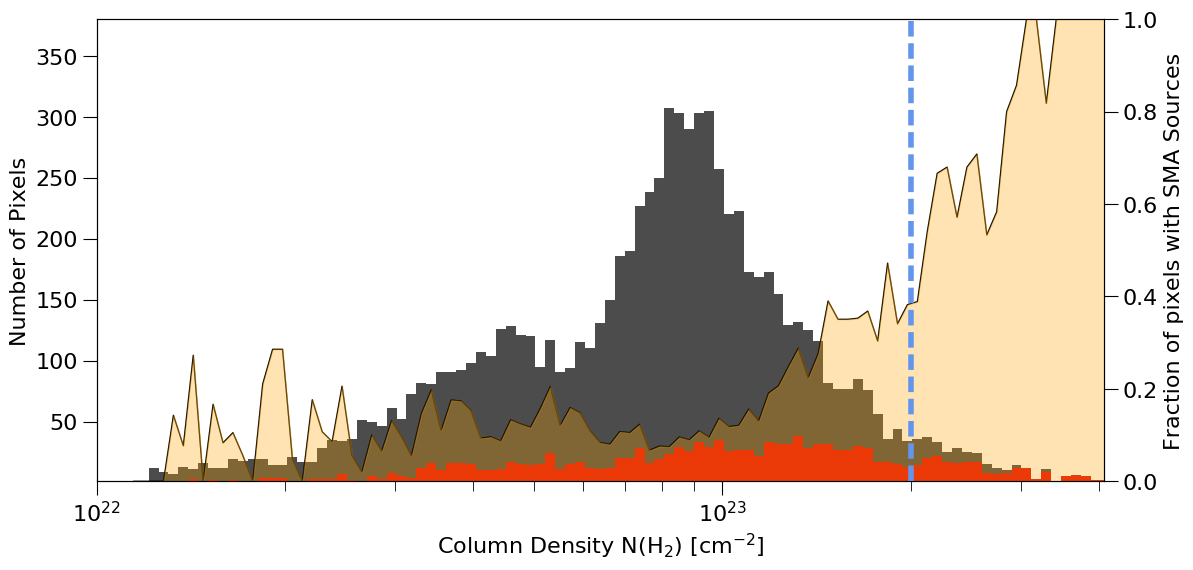

In [31]:
### Make figure of column density
catalog = table_hdu[1].data
column_file = os.path.join(herschel_path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(sma_path, 'CMZoom_continuum_mosaic.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data
column_masked[~smaobserved_projto_herschel] = np.nan

sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 
                                      'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

pb = ProgressBar(len(catalog))
for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    pb.update()

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn-colorblind')
#sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot Histogram
plt.rcParams.update({'font.size': 16}) #set fontsize
histfig = plt.figure(3,figsize=(13,6))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
linbins = np.linspace(colmin, colmax,100)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),100)
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.7, log=False,
                   label='Full cloud')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='red',
                   label='SMA Sources')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
line_frac = ax3.plot(midpts, h2/h1, linestyle='-', color='k', 
                     linewidth=0.95, zorder=-21,label='Fraction of pixels with SMA Sources')
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h2/h1, color='orange',alpha=0.3)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)

vx, vy = [2e23,2e23],[0,1]

ax3.plot(vx,vy,linestyle='--',linewidth=4.0,color='cornflowerblue')
ax.set_xscale("log")


ax.set_xlim(1e22, colmax-1e22)

ax.set_ylim(1,380)
#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
ax.tick_params(axis='both',which='major',direction='out',length=10)
ax.tick_params(axis='both',which='minor',direction='out',length=7.5)
ax3.tick_params(axis='both',which='major',direction='out',length=10)

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

In [59]:
print p1
print p2
print h2/h1

<a list of 99 Patch objects>
<a list of 99 Patch objects>
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08333333 0.         0.
 0.         0.02941176 0.02272727 0.02380952 0.         0.
 0.01694915 0.         0.         0.06557377 0.02702703 0.04819277
 0.04545455 0.01941748 0.04545455 0.03603604 0.04807692 0.06024096
 0.13131313 0.11111111 0.07228916 0.07843137 0.0776699  0.09836066
 0.12328767 0.11299435 0.13114754 0.15086207 0.08403361 0.08494208
 0.11858974 0.15238095 0.15231788 0.17088608 0.15673981 0.16176471
 0.10300429 0.10373444 0.11229947 0.12903226 0.17837838 0.22485207
 0.21656051 0.24516129 0.26896552 0.2826087  0.30851064 0.27710843
 0.25301205 0.32183908 0.30379747 0.27118644 0.38461538 0.28888889
 0.39473684 0.37837838 0.5        0.6969697  0.64       0.67857143
 0.72       0.75       0.53333333 0.58333333

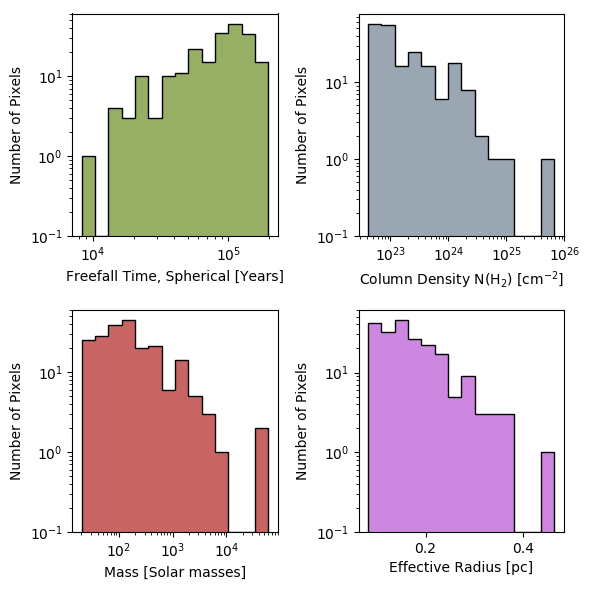

In [32]:

### Plot Histograms

#
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_spherical), max(tff_spherical)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff_spherical,
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[0,0].hist(tff_spherical,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,0].set_xscale("log")
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass), max(mass)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass,
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='SMA Clumps')
h12,l1,p1 = axarr[1,0].hist(mass,
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
####
axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Effective Radius [pc]')
reffmin, reffmax = min(r_eff_pc), max(r_eff_pc)
reff_linbins = np.linspace(reffmin, reffmax,15)
h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
                   reff_linbins, color='mediumorchid',alpha=0.7, log=True,
                   label='SMA Clumps')
h1,l1,p1 = axarr[1,1].hist(r_eff_pc,
                   reff_linbins, color='k',alpha=1.0,histtype='step', log=True)

#axarr[1,1].set_xscale("log")
####

plt.tight_layout()

#legend = plt.legend(loc='upper left', shadow=False, fontsize=18)#'x-large')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [34]:
### Takes mass in solar masses and volume density constant in 1/cm^3 and gives radius in parsec.
def radius_from_mass_const_vol_density(Mass_solar,vol_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    vol_dens = vol_dens *  percm2perm
    #print vol_dens
    Radius_cubed = (Mass / (mu * mh * vol_dens)) / ((4. / 3.)*np.pi)
    #print Radius_cubed
    Radius_cm = Radius_cubed**(1./3.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc


def radius_from_mass_const_col_density(Mass_solar,col_dens):
    #print Mass_solar
    Mass = Mass_solar * (msun/1000.0)
    #print Mass
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2

    Radius_sqrd = (Mass / (mu * mh * col_dens)) / (np.pi)
    #print Radius_cubed
    Radius_cm = Radius_sqrd**(1./2.)
    #print Radius_cm
    Radius_pc = Radius_cm / (pc2cm/100)
    return Radius_pc
   
    
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm)#/100) 
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )

    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )

    Mass = Mass / msun

    return Mass

def flux_calc_submm( Wave, Temp, Kappa, Mass, Obj_Dist ):
    
    Mass = Mass * msun
    
    Obj_Dist = Obj_Dist * pc2cm

    #from planck_func import planck_wave

    B = planck_wave( Wave, Temp )
    
    Integrated_Flux = (Mass*Kappa*B)/(Obj_Dist**2.)

    return Integrated_Flux


(2,)
(2,)


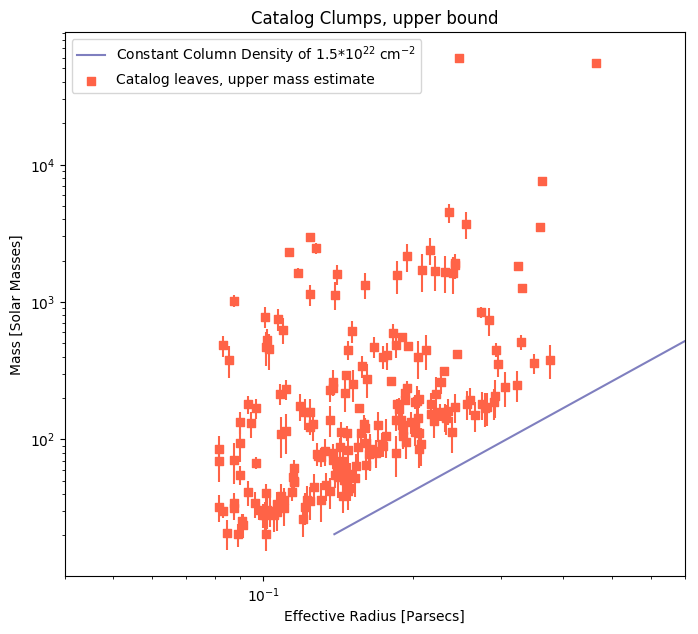

In [35]:
### MR plot

plt.close()
plt.rcParams.update({'font.size': 10}) #set fontsize
mrfig = plt.figure(3,figsize=(8,8))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
ax.set_title('Catalog Clumps, upper bound')
pcolor = 'tomato'
ax.scatter(r_eff_pc, mass,s=30, color=pcolor,marker='s',alpha=1.,label='Catalog leaves, upper mass estimate')
ax.errorbar(x=r_eff_pc, y=mass, yerr=noise_mass, ls='none',color=pcolor,alpha=1.)

## constant volume density line
 
#print min(mass)
#print max(mass)

#logspace_masses = np.logspace(min(mass), max(mass),100)

#print radius_from_mass_const_vol_density(mass,10**4)
#ax.plot(mass,radius_from_mass_const_vol_density(mass,10**4),label='Constant Volume Density of 10$^{4}$ cm$^{-2}$')
#ax.plot(mass,radius_from_mass_const_vol_density(mass,10**7),label='Constant Volume Density of 10$^{7}$ cm$^{-2}$')
#ax.plot(mass,radius_from_mass_const_vol_density(mass,10**(5.5)),label='Constant Volume Density of 10$^{5.5}$ cm$^{-2}$')


#ax.plot(mass,radius_from_mass_const_col_density(mass,10**24),label='Constant Column Density of 10$^{24}$ cm$^{-2}$')
#ax.plot(mass,radius_from_mass_const_col_density(mass,1.6*10**23),label='Constant Column Density of 1.6*10$^{23}$ cm$^{-2}$')
#ax.plot(mass,radius_from_mass_const_col_density(mass,10**22),label='Constant Column Density of 10$^{22}$ cm$^{-2}$')

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(4e-2,0.7)


plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
mass_bin = np.array([min(mass),max(mass)])
print mass_bin.shape
radius_vals = radius_from_mass_const_col_density(mass_bin,1.5*10**22)
print radius_vals.shape
ax.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 1.5*10$^{22}$ cm$^{-2}$',linestyle='-',alpha=0.5)

legend = plt.legend(loc='upper left', shadow=False, fontsize=10)#'x-large')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'no_line_mass_radius'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

(2,)
(2,)


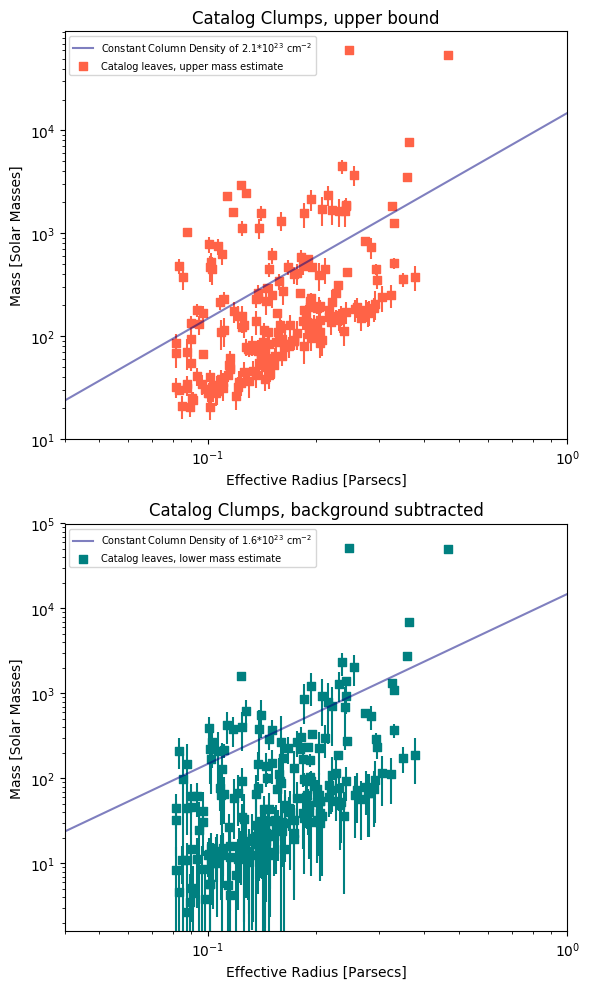

In [36]:
## side by side
plt.rcParams.update({'font.size': 10}) #set fontsize

#radius_vals = radius_from_mass_const_col_density(mass,2.1*10**23)
mass_bin = np.array([min(mass),max(mass)])
print mass_bin.shape
radius_vals = radius_from_mass_const_col_density(mass_bin,2.1*10**23)
print radius_vals.shape

f = plt.figure(figsize=(6,10))

#plt.xlabel('Effective Radius [Parsecs]')
#plt.ylabel('Mass [Solar Masses]')

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Clumps, upper bound')
ax1.scatter(r_eff_pc, mass,s=30, color='tomato',alpha=1.,marker='s',label='Catalog leaves, upper mass estimate')
ax1.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 2.1*10$^{23}$ cm$^{-2}$',alpha=0.5)
ax1.errorbar(x=r_eff_pc, y=mass, yerr=noise_mass, ls='none',color='tomato')

legend = plt.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax1.set_xlabel('Effective Radius [Parsecs]')
ax1.set_ylabel('Mass [Solar Masses]')
ax1.set_xlim(4e-2,1.0)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Clumps, background subtracted')
ax2.scatter(r_eff_pc,mass_bgsub, s=30, color='teal',alpha=1.,marker='s',label='Catalog leaves, lower mass estimate')
ax2.plot(radius_vals,mass_bin,color='navy',label='Constant Column Density of 1.6*10$^{23}$ cm$^{-2}$',alpha=0.5)
ax2.errorbar(x=r_eff_pc, y=mass_bgsub, yerr=noise_mass, ls='none',color='teal')
legend = plt.legend(loc='upper left', shadow=False, fontsize=7)#'x-large')

ax2.set_xlabel('Effective Radius [Parsecs]')
ax2.set_ylabel('Mass [Solar Masses]')
ax2.set_xlim(4e-2,1.0)


ax1.set_xscale("log")
ax1.set_yscale("log")
ax2.set_xscale("log")
ax2.set_yscale("log")

#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis


plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'twofig_subtracted_mass_radius'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

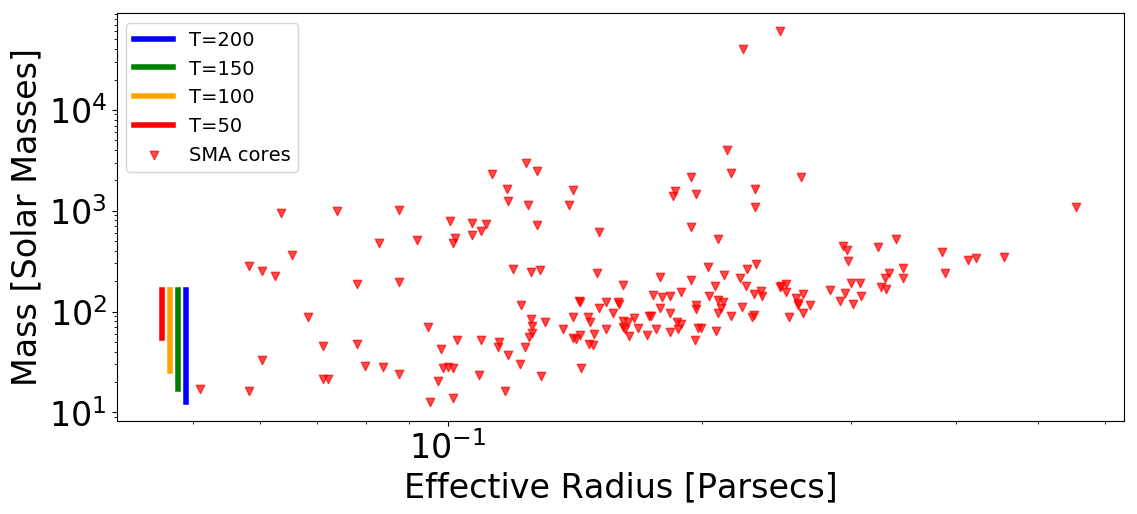

In [8]:
plt.rcParams.update({'font.size': 24}) #set fontsize
mrfig = plt.figure(3,figsize=(13,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass

#for i in range(len(mass)):
#    ax.plot([r_eff_pc[i],r_eff_pc[i]],[mass_bgsub[i],mass[i]],'k-',linewidth='0.2')
ax.scatter(r_eff_pc, mass, color='red',alpha=0.7, label='SMA cores',marker='v')
#ax.scatter(r_eff_pc,mass_bgsub, color='blue',alpha=0.7, label='SMA cores',marker='^')
#ax.plot(mass,radius_from_mass_const_vol_density(mass,10**4),label='Constant Volume Density of 10$^{4}$ cm$^{-2}$')
radius_vals = radius_from_mass_const_col_density(mass,1.6*10**23)

#ax.plot(radius_vals,mass,color='green',label='Constant Column Density of 1.610$^{23}$ cm$^{-2}$')

### plot temp bar
low_dustTemp = 20
high_dustTemp = 50
#flux = table_hdu[1].data['flux_integrated']
flux1 = .02
flux2 = .1
flux3 = 2.
flux4 = 1.
#print flux
#print flux.shape
lowTmass =mass_calc_submm(Wave, low_dustTemp, Kappa, flux2, distance)
highTmass1 = mass_calc_submm(Wave, 50., Kappa, flux2, distance)
highTmass2 = mass_calc_submm(Wave, 100., Kappa, flux2, distance)
highTmass3 = mass_calc_submm(Wave, 150., Kappa, flux2, distance)
highTmass4 = mass_calc_submm(Wave, 200., Kappa, flux2, distance)
#print lowTmass.shape
r_fixed = .049
r_fixed2 = .048
r_fixed3 = .047
r_fixed4 = .046
ax.plot([r_fixed,r_fixed],[lowTmass,highTmass4],'k-',linewidth='4.',color='blue',label='T=200')
ax.plot([r_fixed2,r_fixed2],[lowTmass,highTmass3],'k-',linewidth='4.',color='green',label='T=150')
ax.plot([r_fixed3,r_fixed3],[lowTmass,highTmass2],'k-',linewidth='4.',color='orange',label='T=100')
ax.plot([r_fixed4,r_fixed4],[lowTmass,highTmass1],'k-',linewidth='4.',color='red',label='T=50')

ax.set_xscale("log")
ax.set_yscale("log")

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')


#ax.add_artist(scalebar)

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'mass_radius_temps'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

[0.04       0.12444444 0.20888889 0.29333333 0.37777778 0.46222222
 0.54666667 0.63111111 0.71555556 0.8       ]


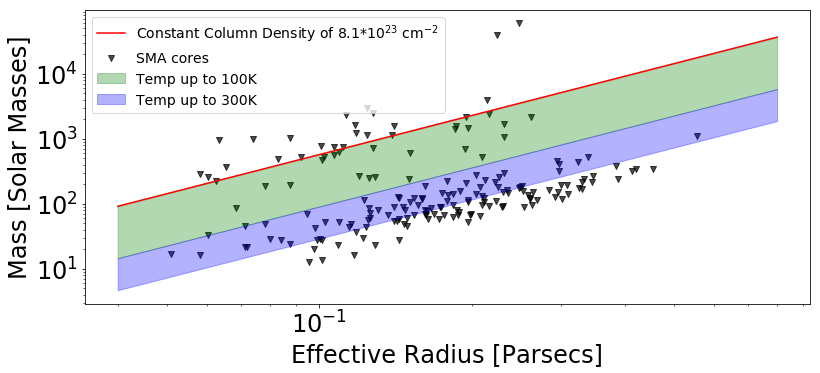

In [9]:
plt.rcParams.update({'font.size': 24}) #set fontsize
mrfig = plt.figure(3,figsize=(13,6))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm/100) 
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

#for i in range(len(mass)):
#    ax.plot([r_eff_pc[i],r_eff_pc[i]],[mass_bgsub[i],mass[i]],'k-',linewidth='0.2')
ax.scatter(r_eff_pc, mass, color='black',alpha=0.7, label='SMA cores',marker='v')
#ax.scatter(r_eff_pc,mass_bgsub, color='blue',alpha=0.7, label='SMA cores',marker='^')
radius_vals_1 = radius_from_mass_const_col_density(mass,8.1*10**23)
radius_vals_2 = radius_from_mass_const_col_density(mass,0.45*10**23)
r_bound_vals = np.linspace(0.04,0.8,10)
#r_bound_vals[0], r_bound_vals[1] = 0.04, 0.8
mass_vals_1 = mass_from_radius_const_col_density(r_bound_vals,8.1*10**23)
mass_vals_2 = mass_from_radius_const_col_density(r_bound_vals,0.45*10**23)
print r_bound_vals
#ax.plot(radius_vals_1,mass,color='green',label='Constant Column Density of 8.1*10$^{23}$ cm$^{-2}$')
ax.plot(r_bound_vals,mass_vals_1,color='red',label='Constant Column Density of 8.1*10$^{23}$ cm$^{-2}$')
#ax.plot(radius_vals_2,mass,color='orange',label='Constant Column Density of 0.45*10$^{23}$ cm$^{-2}$')
#### ax.plot(r_bound_vals,mass_vals_2,color='red',label='Constant Column Density of 4.5*10$^{22}$ cm$^{-2}$')

#ax.plot(radius_vals,mass,color='green',label='Constant Column Density of 1.610$^{23}$ cm$^{-2}$')

### plot temp bar
low_dustTemp = 20
mid_dustTemp = 100
high_dustTemp = 300
#flux = table_hdu[1].data['flux_integrated']
#flux_vals_mid_1 = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass_vals_1,distance)
flux_vals_mid_1 = flux_calc_submm(Wave,low_dustTemp,Kappa,mass_vals_1,distance)
#mass_vals_mid_1 = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_vals_mid_1, distance)
mass_vals_mid_1 = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_vals_mid_1, distance)

#flux_vals_high_1 = flux_calc_submm(Wave,high_dustTemp,Kappa,mass_vals_1,distance)
flux_vals_high_1 = flux_calc_submm(Wave,low_dustTemp,Kappa,mass_vals_1,distance)
#mass_vals_high_1 = mass_calc_submm(Wave,low_dustTemp, Kappa, flux_vals_high_1, distance)
mass_vals_high_1 = mass_calc_submm(Wave,high_dustTemp, Kappa, flux_vals_high_1, distance)

'''
flux1 = .03
flux2 = .1
flux3 = 2.
flux4 = 1.
#print flux
#print flux.shape
lowTmass =mass_calc_submm(Wave, low_dustTemp, Kappa, flux2, distance)
highTmass1 = mass_calc_submm(Wave, 50., Kappa, flux2, distance)
highTmass2 = mass_calc_submm(Wave, 100., Kappa, flux2, distance)
highTmass3 = mass_calc_submm(Wave, 150., Kappa, flux2, distance)
highTmass4 = mass_calc_submm(Wave, 200., Kappa, flux2, distance)
'''

ax.fill_between(r_bound_vals,mass_vals_1,mass_vals_mid_1,color='green',alpha=0.3,label='Temp up to 100K')
ax.fill_between(r_bound_vals,mass_vals_mid_1,mass_vals_high_1,color='blue',alpha=0.3,label='Temp up to 300K')
#ax.plot(r_bound_vals,mass_vals_high_2,color='blue')

ax.set_xscale("log")
ax.set_yscale("log")

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')


# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bin'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [77]:
flux_vals_test = flux_calc_submm(Wave,low_dustTemp,Kappa,mass_vals_1,distance)
mass_vals_test = mass_calc_submm(Wave,low_dustTemp, Kappa, flux_vals_test, distance)
print mass_vals_1
print flux_vals_test
print mass_vals_test

[   91.34040908   884.08494716  2490.99955136  4912.0842217
  8147.33895816 12196.76376076 17060.35862948 22738.12356434
 29230.05856533 36536.16363244]
[2.82306160e-35 2.73244481e-34 7.69894207e-34 1.51817979e-33
 2.51810124e-33 3.76965855e-33 5.27285173e-33 7.02768076e-33
 9.03414565e-33 1.12922464e-32]
[4.59227798e-32 4.44487153e-31 1.25238791e-30 2.46962505e-30
 4.09619857e-30 6.13210848e-30 8.57735477e-30 1.14319374e-29
 1.46958565e-29 1.83691119e-29]


In [91]:
flux_ten = flux_calc_submm(Wave,100,Kappa,10,distance)
print flux_ten
mass_ten = mass_calc_submm(Wave,20,Kappa,flux_ten,distance)
print mass_ten

0.03863055927568501
62.84038105636678


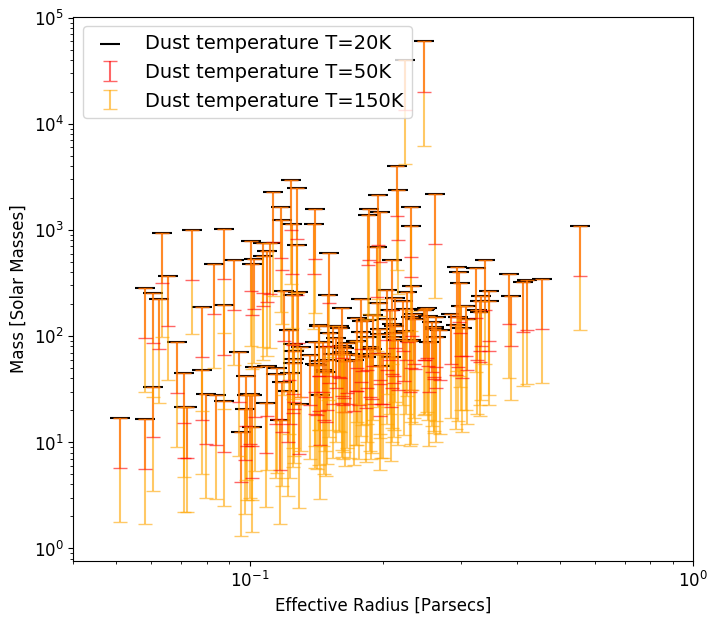

In [21]:
plt.rcParams.update({'font.size': 12}) #set fontsize
#sns.set_style('white')

mrfig = plt.figure(3,figsize=(8,8))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm/100) 
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

#for i in range(len(mass)):
#    ax.plot([r_eff_pc[i],r_eff_pc[i]],[mass_bgsub[i],mass[i]],'k-',linewidth='0.2')


### plot temp bar
low_dustTemp = 20
mid_dustTemp = 50
high_dustTemp = 150
#flux = table_hdu[1].data['flux_integrated']
#flux_vals_mid_1 = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_mid = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass,distance)
#mass_vals_mid_1 = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_vals_mid_1, distance)
mass_vals_mid = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_integrated, distance)

#flux_vals_high_1 = flux_calc_submm(Wave,high_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_high = flux_calc_submm(Wave,high_dustTemp,Kappa,mass,distance)
#mass_vals_high_1 = mass_calc_submm(Wave,low_dustTemp, Kappa, flux_vals_high_1, distance)
mass_vals_high = mass_calc_submm(Wave,high_dustTemp, Kappa, flux_integrated, distance)
mass_diff_mid = mass_vals_mid - mass
mass_diff_high = mass_vals_high - mass

'''
flux1 = .03
flux2 = .1
flux3 = 2.
flux4 = 1.
#print flux
#print flux.shape
lowTmass =mass_calc_submm(Wave, low_dustTemp, Kappa, flux2, distance)
highTmass1 = mass_calc_submm(Wave, 50., Kappa, flux2, distance)
highTmass2 = mass_calc_submm(Wave, 100., Kappa, flux2, distance)
highTmass3 = mass_calc_submm(Wave, 150., Kappa, flux2, distance)
highTmass4 = mass_calc_submm(Wave, 200., Kappa, flux2, distance)
'''

#ax.fill_between(r_bound_vals,mass_vals_2,mass_vals_mid_2,color='green',alpha=0.3)
#ax.fill_between(r_bound_vals,mass_vals_mid_2,mass_vals_high_2,color='blue',alpha=0.3)
#ax.plot(r_bound_vals,mass_vals_high_2,color='blue')

#ax.scatter(r_eff_pc, mass, color='black',alpha=1.0, label='Assumed  dust temperature T=20',marker='_',s=200)
zeros = np.zeros(shape = mass.shape)

ax.errorbar(x=r_eff_pc, y=mass, yerr=[zeros,mass_diff_mid], ls='none',color='red',
            alpha = 0.6,label='Dust temperature T=50K',capsize=5)
ax.errorbar(x=r_eff_pc, y=mass, yerr=[zeros,mass_diff_high], ls='none',color='orange',
            alpha = 0.6,label='Dust temperature T=150K', capsize=5)
ax.scatter(r_eff_pc, mass, color='black',alpha=1.0, label='Dust temperature T=20K',marker='_',s=200)


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(4e-2,1.0)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=14)#'x-large')



# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=10, bbox_inches='tight')
plt.show()

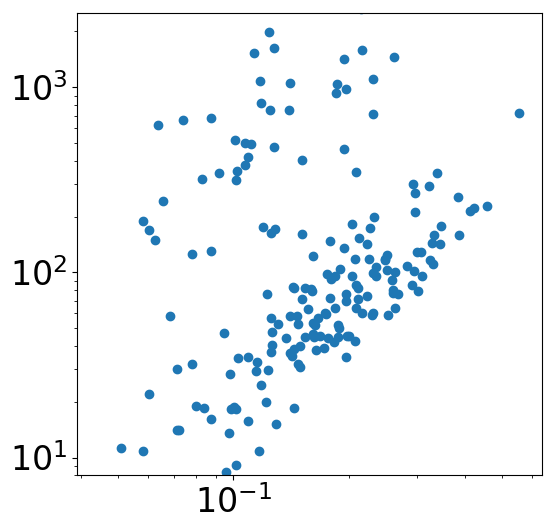

In [33]:
plt.rcParams.update({'font.size': 24}) #set fontsize
mrfig = plt.figure(3,figsize=(6,6))
mrfig.clf()
ax = mrfig.gca()
ax.scatter(r_eff_pc,-mass_diff_mid)
ax.set_ylim(8,2500)
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

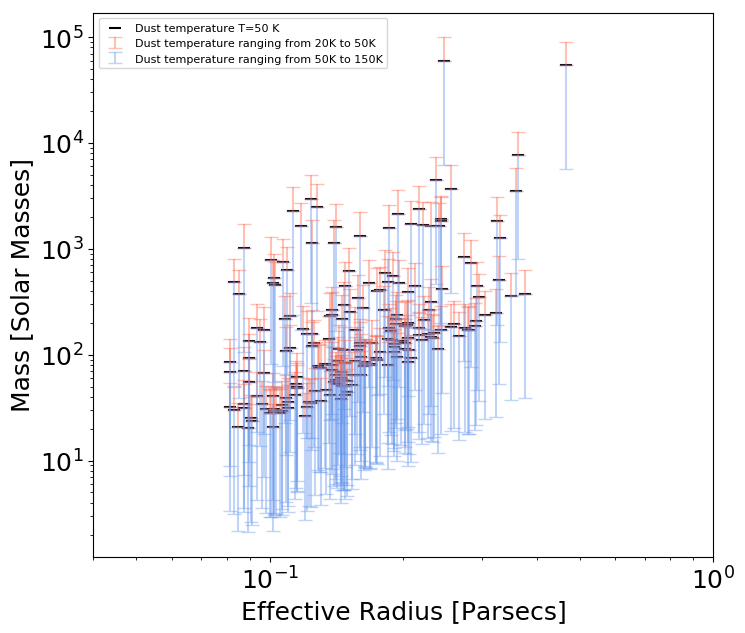

In [38]:
# new "shower" figure based on adam's suggestion
plt.rcParams.update({'font.size': 18}) #set fontsize
mrfig = plt.figure(3,figsize=(8,8))
mrfig.clf()
ax = mrfig.gca()
plt.xlabel('Effective Radius [Parsecs]')
plt.ylabel('Mass [Solar Masses]')
#print mass
def mass_from_radius_const_col_density(Radius_pc,col_dens):
    Radius_cm = Radius_pc * (pc2cm/100) 
    col_dens = col_dens * (10**4) #convert from cm^-2 to m^-2
    Radius_sqrd = Radius_cm**2
    Mass = Radius_sqrd * (np.pi) * (mu * mh * col_dens)
    
    Mass_solar = Mass / (msun/1000.0)
    return Mass_solar

#for i in range(len(mass)):
#    ax.plot([r_eff_pc[i],r_eff_pc[i]],[mass_bgsub[i],mass[i]],'k-',linewidth='0.2')


### plot temp bar
low_dustTemp = 20
mid_dustTemp = 50
high_dustTemp = 150
#flux = table_hdu[1].data['flux_integrated']
#flux_vals_mid_1 = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_mid = flux_calc_submm(Wave,mid_dustTemp,Kappa,mass,distance)
#mass_vals_mid_1 = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_vals_mid_1, distance)
mass_vals_mid = mass_calc_submm(Wave, mid_dustTemp, Kappa, flux_integrated, distance)

#flux_vals_high_1 = flux_calc_submm(Wave,high_dustTemp,Kappa,mass_vals_1,distance)
#flux_vals_high = flux_calc_submm(Wave,high_dustTemp,Kappa,mass,distance)
#mass_vals_high_1 = mass_calc_submm(Wave,low_dustTemp, Kappa, flux_vals_high_1, distance)
mass_vals_high = mass_calc_submm(Wave,high_dustTemp, Kappa, flux_integrated, distance)
mass_diff_mid = mass_vals_mid - mass
mass_diff_high = mass_vals_high - mass

'''
flux1 = .03
flux2 = .1
flux3 = 2.
flux4 = 1.
#print flux
#print flux.shape
lowTmass =mass_calc_submm(Wave, low_dustTemp, Kappa, flux2, distance)
highTmass1 = mass_calc_submm(Wave, 50., Kappa, flux2, distance)
highTmass2 = mass_calc_submm(Wave, 100., Kappa, flux2, distance)
highTmass3 = mass_calc_submm(Wave, 150., Kappa, flux2, distance)
highTmass4 = mass_calc_submm(Wave, 200., Kappa, flux2, distance)
'''

#ax.fill_between(r_bound_vals,mass_vals_2,mass_vals_mid_2,color='green',alpha=0.3)
#ax.fill_between(r_bound_vals,mass_vals_mid_2,mass_vals_high_2,color='blue',alpha=0.3)
#ax.plot(r_bound_vals,mass_vals_high_2,color='blue')

ax.scatter(r_eff_pc, mass, color='black',alpha=1.0, label='Dust temperature T=50 K',marker='_',s=80.)
zeros = np.zeros(shape = mass.shape)
ax.errorbar(x=r_eff_pc, y=mass, yerr=[mass_diff_mid,zeros], ls='none',color='tomato',alpha = 0.4,
            label='Dust temperature ranging from 20K to 50K',capsize=5)

ax.errorbar(x=r_eff_pc, y=mass, yerr=[zeros,mass_diff_high], ls='none',color='cornflowerblue',alpha = 0.4,
            label='Dust temperature ranging from 50K to 150K',capsize=5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(4.0e-2,1.0)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=8)#'x-large')


# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [46]:
### make lb plot with 

glon = mtable['glon']
glat = mtable['glat']
glon_bins = np.linspace(-0.8,1.8,20)
glat_bins = np.linspace(-0.2,0.1,15)

plt.rcParams.update({'font.size': 24}) #set fontsize
fig = plt.figure(3,figsize=(13,6))
fig.clf()
ax = fig.gca()
plt.xlabel('Galactic Longitude [degrees]')
plt.ylabel('Galactic Latitude [degrees]')
ax.scatter(glon, glat, color='black',s=30,marker='D',alpha = 1.,label='l-b distribution of leaves')
ax2 = ax.twinx(ymax=100)
ax2.set_ylabel('Number of Leaves')
ax2.hist(glon,glon_bins,color='red',alpha=0.4,label='Galactic Longitude histogram of leaves')
#ax2.set_xlim(xmax=100)
ax3 = ax.twiny(xmax=100)
ax3.set_xlabel('Number of Leaves')
ax3.hist(glat,glat_bins,orientation='horizontal',color='blue',alpha=0.4,label='Galactic Latitude distribution of leaves')
#ax3.set_ylim(ymax=100)
plt.show()

TypeError: twinx() got an unexpected keyword argument 'ymax'

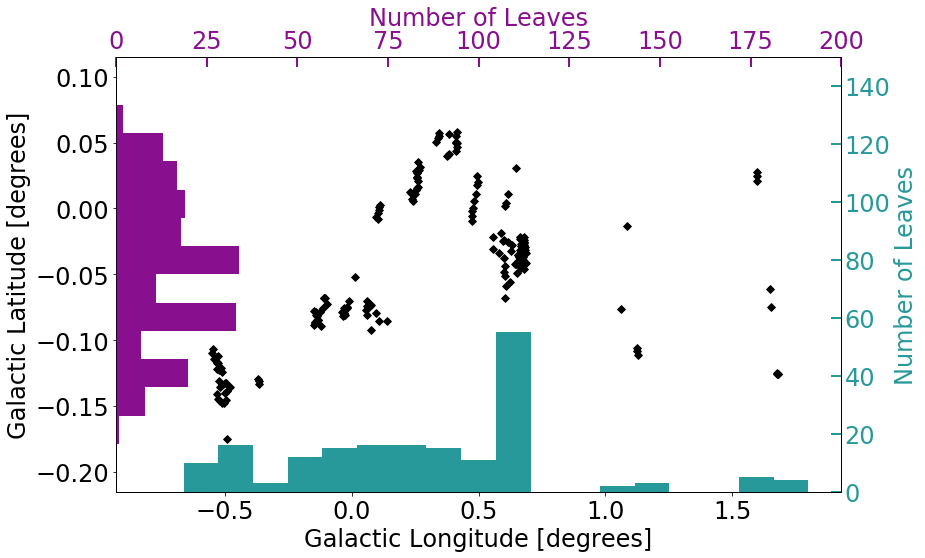

In [94]:
### make lb plot with 
plt.close()
glon = mtable['glon']
glat = mtable['glat']
glon_bins = np.linspace(-0.8,1.8,20)
glat_bins = np.linspace(-0.2,0.1,15)

xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'

plt.rcParams.update({'font.size': 24}) #set fontsize
fig = plt.figure(3,figsize=(13,8))
fig.clf()
ax = fig.add_subplot(111)
ax.set_xlabel('Galactic Longitude [degrees]')
ax.set_ylabel('Galactic Latitude [degrees]')
ax.scatter(glon, glat, color='black',s=30,marker='D',alpha = 1.,label='l-b distribution of leaves')
ax2 = ax.twinx()
ax2.set_ylabel('Number of Leaves',color=xcolor)
ax2.hist(glon,glon_bins,color=xcolor,alpha=1.0,label='Galactic Longitude histogram of leaves')
ax2.set_ylim(0,150)
ax2.tick_params(width=2, length=10, color = xcolor,labelcolor=xcolor,direction='in')
ax3 = ax.twiny()
ax3.set_xlabel('Number of Leaves',color=ycolor)
ax3.tick_params(width=2, length=10, color = ycolor,labelcolor=ycolor,direction='in')
ax3.hist(glat,glat_bins,orientation='horizontal',color=ycolor,alpha=1.,label='Galactic Latitude distribution of leaves')
ax3.set_xlim(0,200)
plt.show()

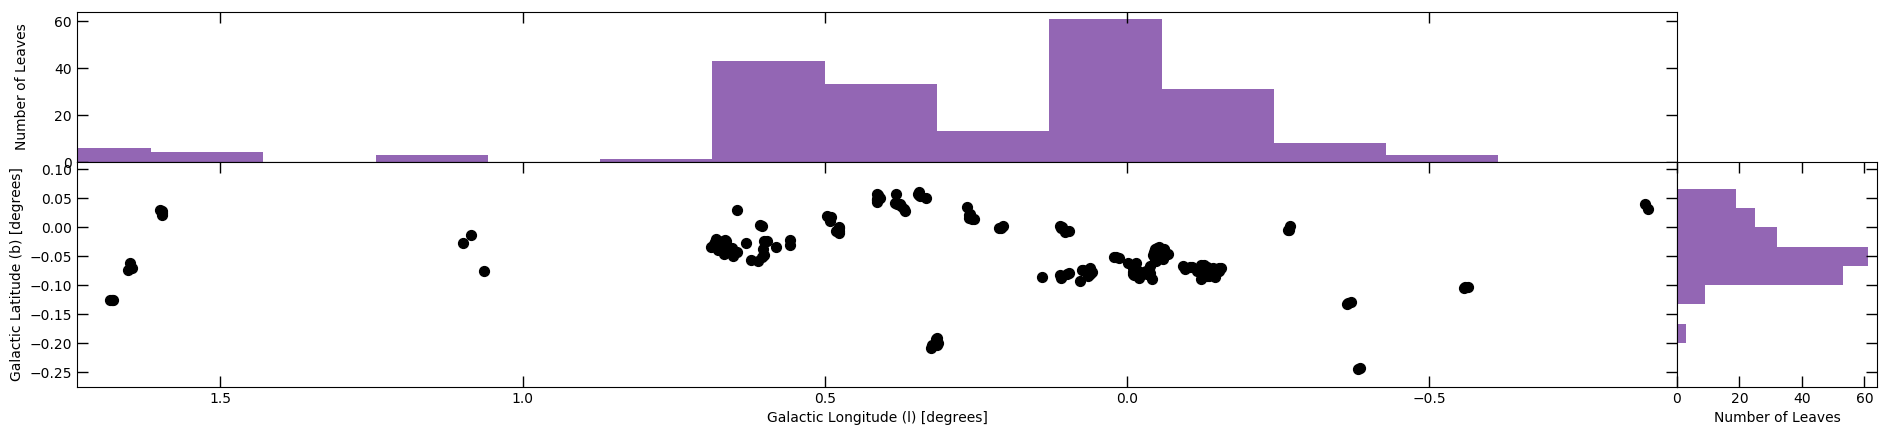

In [40]:
### make lb plot with 
plt.close()
#sns.set_style('white')
glon = mtable['glon']
glat = mtable['glat']
glon_bins = np.linspace(-0.8,1.8,15)
glat_bins = np.linspace(-0.2,0.1,10)


xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'
xcolor = 'indigo'
ycolor = 'indigo'

#mosaic_image = fits.getdata(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
left = 0.1
width = 0.8
fig = plt.figure(3,figsize=(20,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])
ax2 = fig.add_axes([0.1, 0.01, 0.8, 0.75], sharex=ax1)
ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75], sharey=ax2)

#ax2 = plt.subplot(223)
ax2.set_xlabel('Galactic Longitude (l) [degrees]')
ax2.set_ylabel('Galactic Latitude (b) [degrees]')
#ax2.imshow(mosaic_image)
ax2.set_xlim(-0.91,1.737)
ax2.set_ylim(-0.275,0.1133)
ax2.scatter(glon, glat, color='k',s=50,marker='o',alpha = 1.,label='l-b distribution of leaves')
ax2.tick_params(width=1, length=8,direction='in',top=True,right=True)
ax2.invert_xaxis()

#ax1 = plt.subplot(221)
ax1.set_ylabel('Number of Leaves', labelpad=18)
ax1.hist(glon,glon_bins,color=xcolor,alpha=.6,label='Galactic Longitude histogram of leaves')
ax1.set_xlim(-0.91,1.737)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=False)
ax1.invert_xaxis()

#ax3 = plt.subplot(224)
ax3.set_xlabel('Number of Leaves')
#ax3.tick_params(width=2, length=10, color = ycolor,labelcolor=ycolor,direction='in')
ax3.hist(glat,glat_bins,orientation='horizontal',color=ycolor,
         alpha=0.6,label='Galactic Latitude distribution of leaves')
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=False,labelleft=False)
plt.savefig(path + 'lb_hist'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

0.4968
[array(12508.60300757), array(1982.18447999)]
18268.608761367504
(2800, 19000)


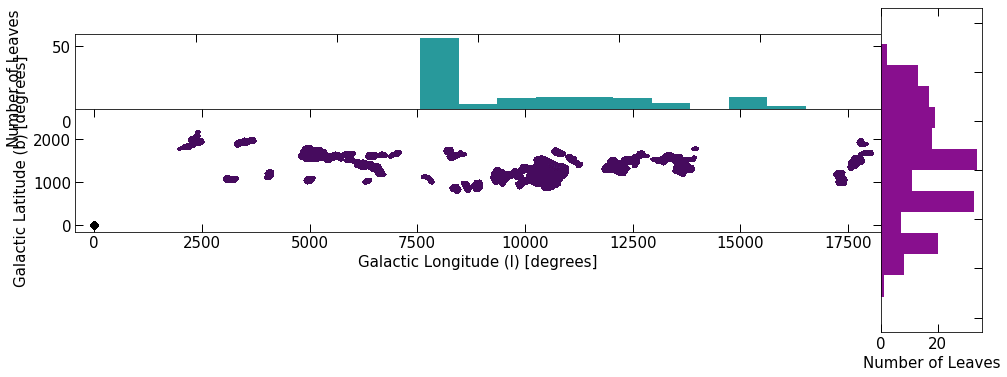

In [56]:
### make lb plot with 
import aplpy
from astropy import wcs
plt.close()
glon = mtable['glon']
glat = mtable['glat']
glon_bins = np.linspace(-0.8,1.8,20)
glat_bins = np.linspace(-0.2,0.1,15)
glon_cen, glat_cen = 12509, 1982
degperpix = (1.38e-4)*3600
print degperpix
w = wcs.WCS(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits').celestial
mosaic_image = fits.getdata(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
mosaic_image = mosaic_image
print w.wcs_world2pix(0,0,0)
glon_min, glon_max = w.wcs_world2pix(-0.8,0,0)[0], w.wcs_world2pix(1.8,0,0)[0]
glat_min, glat_max = w.wcs_world2pix(0,-0.2,0)[1], w.wcs_world2pix(0,0.1,0)[1]
print glon_min
print mosaic_image.shape
#mosaic_image = len(mosaic_image[0][:])

left = 0.1
width = 0.8
fig = plt.figure(3,figsize=(14,6))
fig.clf()
plt.rcParams.update({'font.size': 15}) #set fontsize
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.2])
ax2 = fig.add_axes([0.1, 0.01, .8, 0.75])
ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])

#ax2 = plt.subplot(223)
ax2.set_xlabel('Galactic Longitude (l) [degrees]')
ax2.set_ylabel('Galactic Latitude (b) [degrees]')
ax2.imshow(mosaic_image,extent=(glon_min,glon_max,glat_min,glat_max))
ax2.scatter(glon, glat, color='black',s=30,marker='D',alpha = 1.,label='l-b distribution of leaves')
ax2.tick_params(width=1, length=8,direction='in',top=True,right=True)
ax2.invert_xaxis()

#ax1 = plt.subplot(221)
ax1.set_ylabel('Number of Leaves', labelpad=30)
ax1.hist(glon,glon_bins,color=xcolor,alpha=1.0,label='Galactic Longitude histogram of leaves')
#ax1.set_ylim(0,150)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=False)
ax1.invert_xaxis()

#ax3 = plt.subplot(224)
ax3.set_xlabel('Number of Leaves')
#ax3.tick_params(width=2, length=10, color = ycolor,labelcolor=ycolor,direction='in')
ax3.hist(glat,glat_bins,orientation='horizontal',color=ycolor,
         alpha=1.,label='Galactic Latitude distribution of leaves')
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=False,labelleft=False)
plt.show()
#plt.savefig(figure_path + 'lb_hist'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

In [30]:
print ax1.get_xlim()

(1.9300000000000002, -0.93)


In [ ]:
### This is the simobserve part    
simobserve(project='sim_temp',
           skymodel=path+'initial_temp_image.fits',
           incenter='230GHz',
           inwidth='50MHz',
           antennalist='sma.subcompact.cfg',
           totaltime='28800s',
           incell='0.5arcsec',
           graphics='none',
           verbose=True,
           overwrite=True)

### This is the tclean part
Phase_Center = 'J2000 267.35684deg -27.559915deg'
Phase_Center_GC = 'G 1.610deg -0.0045deg'
vis = 'sim_temp/sim_temp.sma.subcompact.noisy.ms'
CellSize_DW = '0.5arcsec'
CellSize = '0.00013deg'
thresh_cont='0.001Jy/beam'
niter_cont=100000

tclean(vis = vis,
       imagename = path+'sim_temp.cont.tclean',
       phasecenter = Phase_Center_GC,
       specmode = 'mfs',
       deconvolver = 'multiscale',
       scales = [0,3,9,27], #[0,9,27]
       imsize = 200,
       weighting = 'briggs',
       robust = 0.5,
       niter = niter_cont,
       threshold = thresh_cont,
       interactive = False,
       gridder = 'mosaic',
       noisethreshold = 5.0, #
       lownoisethreshold = 1.5, #
       usemask = 'auto-thresh',
       pbcor = True)
       #cell = CellSize_DW,